In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit
from convokit import TextParser, TensorDecomposer, Corpus, download

In [3]:
corpus = Corpus('convokit/tensor_decomposer/experiments/coarse-discourse-subset')

In [4]:
convo_df = corpus.get_conversations_dataframe()

In [5]:
dis_8 = 0
for convo_id in convo_df[convo_df['meta.longest_path'] >= 8].index:
    convo = corpus.get_conversation(convo_id)
    utts = convo.get_chronological_utterance_list()
    if utts[7].meta['disagreement'] == 1 or utts[6].meta['disagreement']:
        dis_8 += 1

In [6]:
dis_8

201

In [7]:
len(convo_df[convo_df['meta.longest_path'] >= 8])

838

In [158]:
td = TensorDecomposer(feature_set=['annot-dict-{}'.format(idx) for idx in range(1, 6+1)], 
                      obj_type="conversation", tensor_func='tensortools-ncp-bcd', rank=30,
                     )

In [159]:
td.fit(corpus, selector=lambda convo: convo.meta['longest_path'] >= 8)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.8320386030034206, improvement inf.
NCP_BCD: iteration 2, objective 0.7879337547907226, improvement 0.044104848212698.
NCP_BCD: iteration 3, objective 0.7407877426378768, improvement 0.04714601215284575.
NCP_BCD: iteration 4, objective 0.7052504921352808, improvement 0.03553725050259604.
NCP_BCD: iteration 5, objective 0.6742753235540614, improvement 0.030975168581219403.
NCP_BCD: iteration 6, objective 0.6432439494029386, improvement 0.03103137415112278.
NCP_BCD: iteration 7, objective 0.61169837025558, improvement 0.03154557914735856.
NCP_BCD: iteration 8, objective 0.5787369623974004, improvement 0.03296140785817969.
NCP_BCD: iteration 9, objective 0.5500033491436166, improvement 0.028733613253783763.
NCP_BCD: iteration 10, objective 0.526283803921373, improvement 0.02371954522224362.
NCP_BCD: iteration 11, objective 0.5060126603885409, improvement 0.020271143532832103.
NCP_BCD: iteration 12, objective

Directory already exists. Exiting summarize()


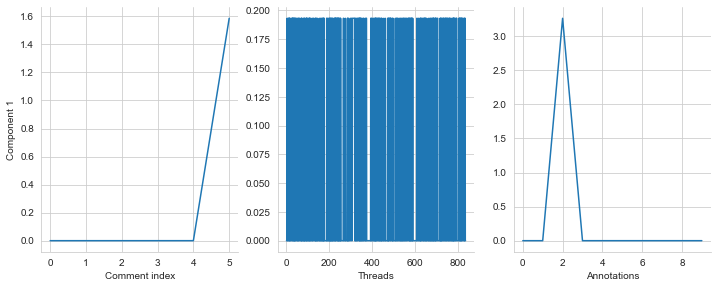

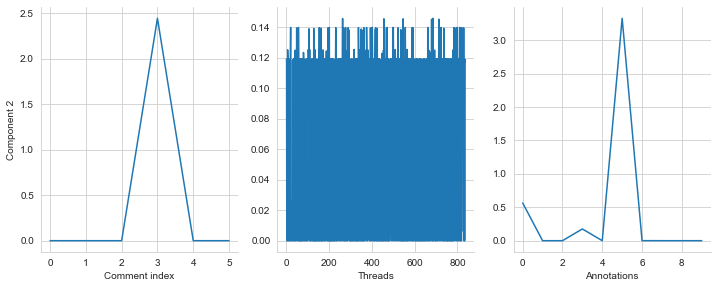

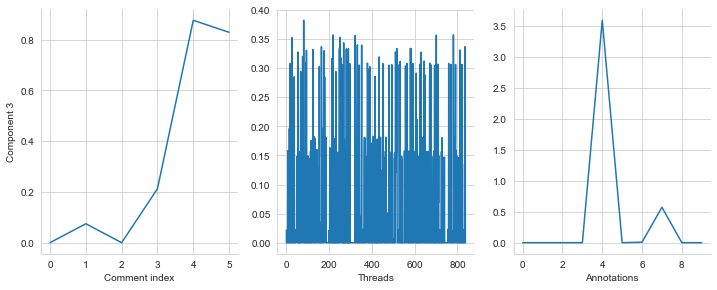

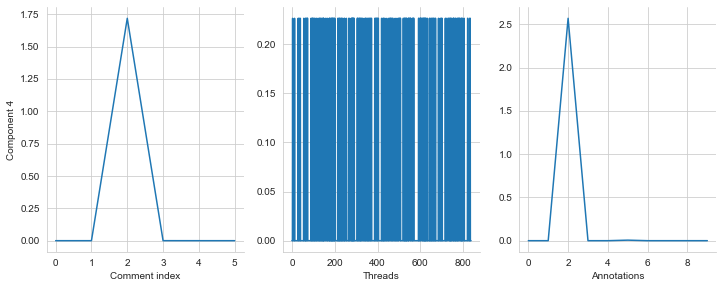

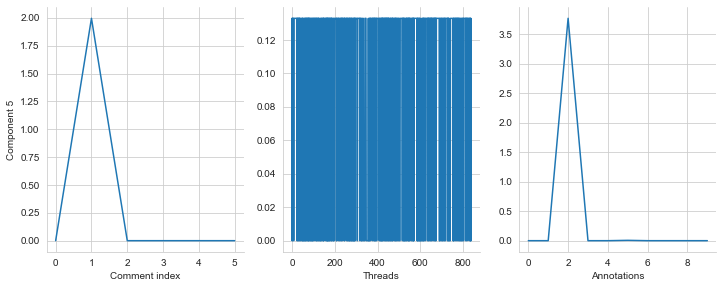

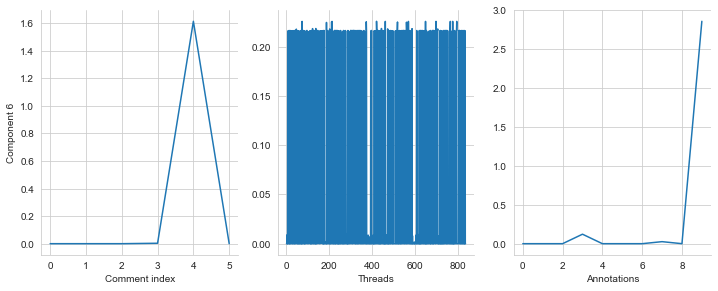

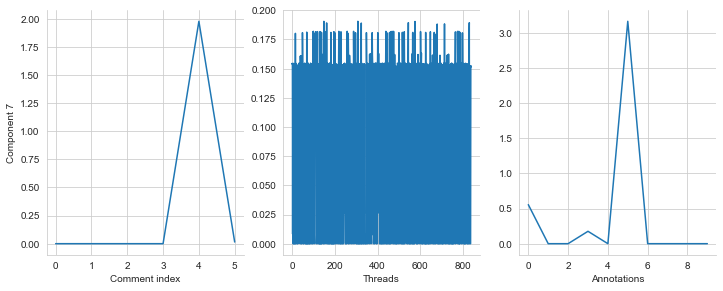

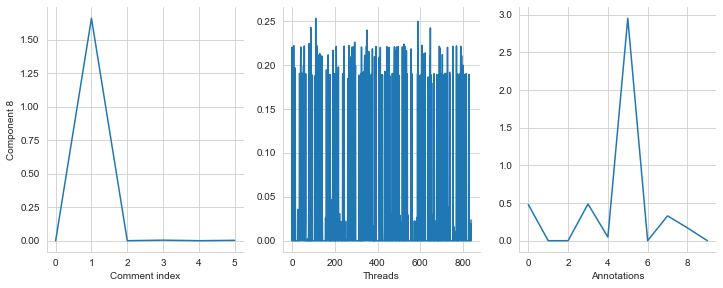

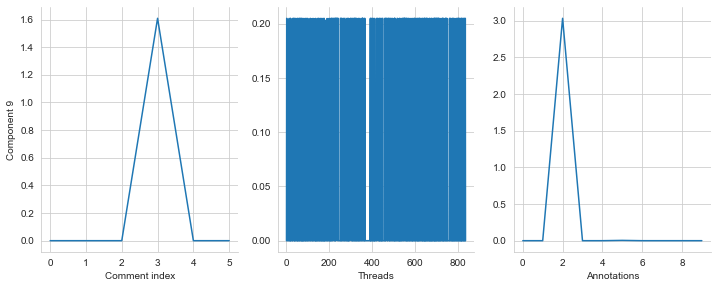

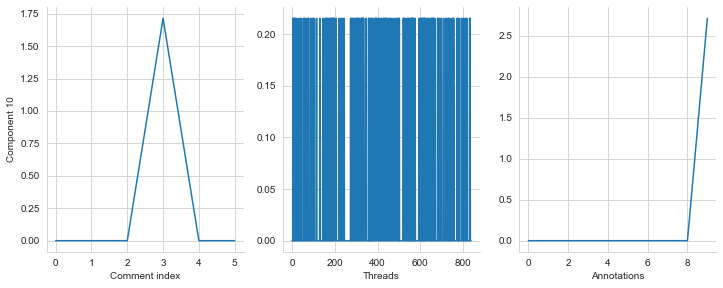

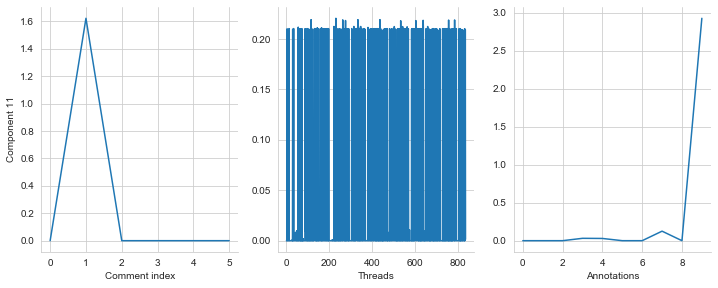

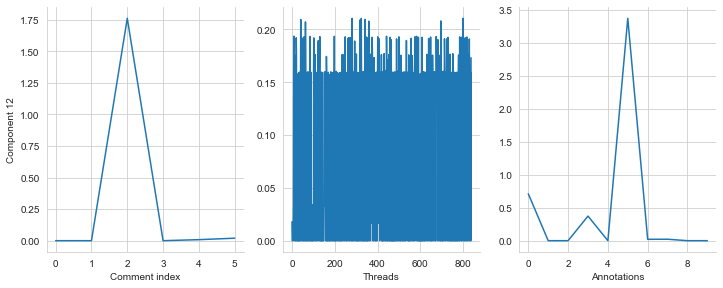

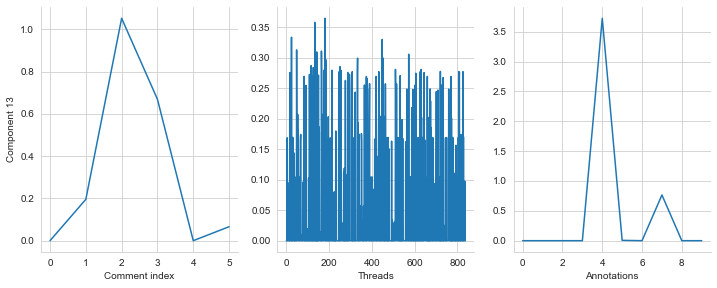

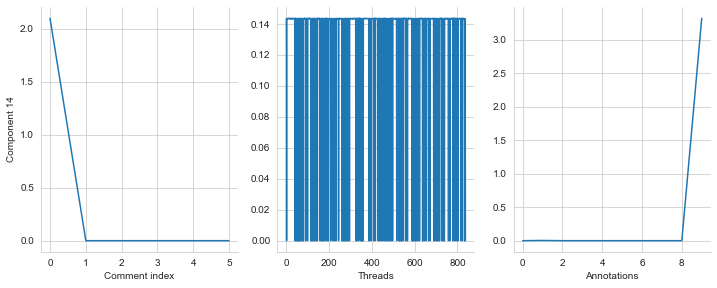

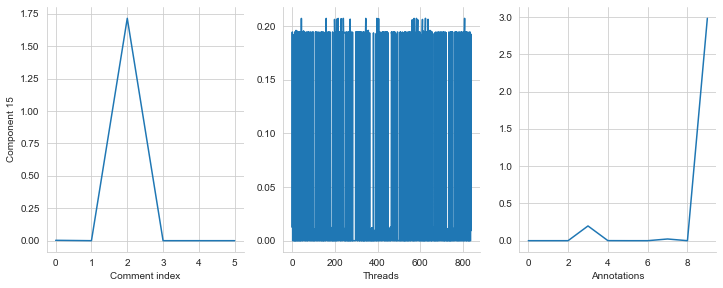

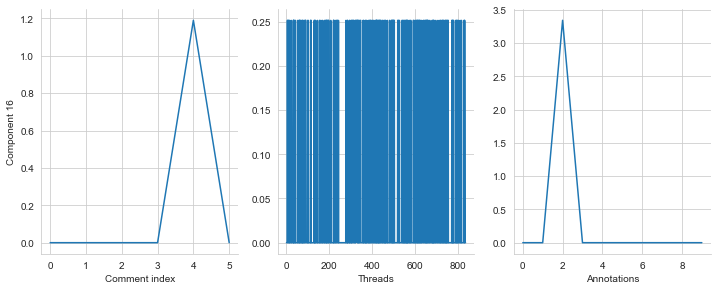

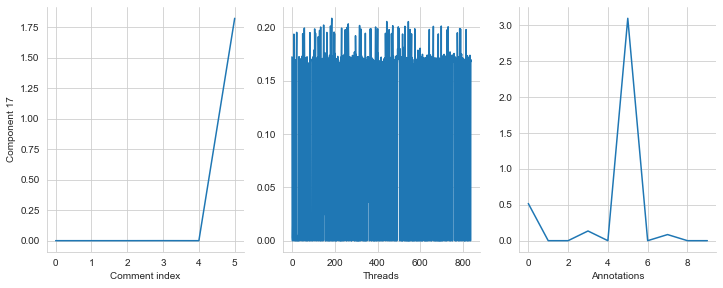

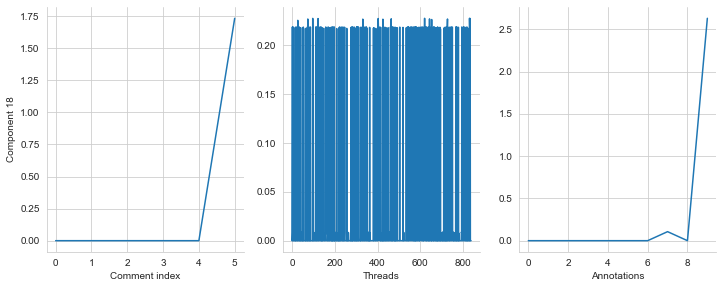

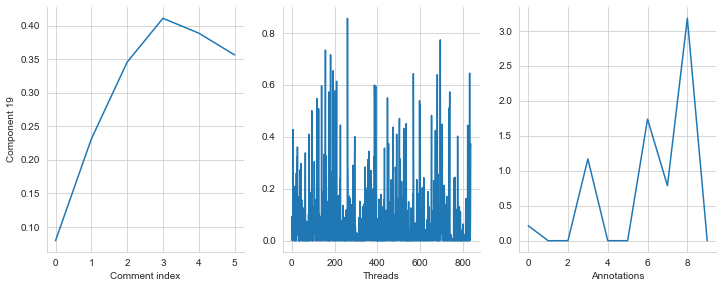

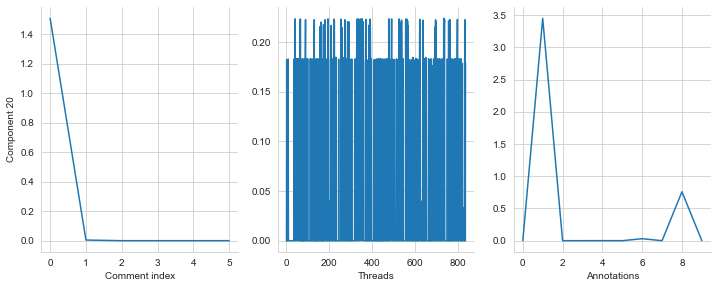

In [129]:
td.summarize(corpus, axis_names=['Comment index', 'Threads', 'Annotations'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

In [24]:
from convokit import Classifier
import numpy as np
from convokit import BoWClassifier

In [15]:
long_8 = lambda convo: convo.meta['longest_path'] >= 8

In [17]:
for convo in corpus.iter_conversations(long_8):
    utts = convo.get_chronological_utterance_list()
    convo.meta['ends_disg'] = utts[6].meta['disagreement'] or utts[7].meta['disagreement']

### Tensor classifier

In [160]:
td.transform(corpus, selector=long_8)

In [161]:
model = Pipeline([("standardScaler", StandardScaler(with_mean=False)),
                            ("logreg", LogisticRegression(solver='liblinear'))])

In [162]:
clf_tensor = BoWClassifier(obj_type="conversation", vector_name='tensor_factor', 
                           labeller=lambda convo: convo.meta['ends_disg'],
                clf_feat_name='tensor-pred', clf_prob_feat_name='tensor-pred-score',
                           clf=model
                )

In [188]:
res = clf_tensor.evaluate_with_cv(corpus, selector=long_8, cv=KFold(n_splits=5, shuffle=True))

Using corpus objects...

Running a cross-validated evaluation...
Done.


In [189]:
np.mean(res)

0.8126746506986027

In [26]:
ctr = 0
for convo in corpus.iter_conversations(long_8):
    ctr += int(convo.meta['ends_disg'])

In [30]:
base_accuracy = 1 - ctr / 838
base_accuracy

0.7601431980906921

In [141]:
clf_tensor.fit(corpus, selector=long_8)

In [142]:
clf_tensor.get_model().named_steps['logreg']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [143]:
clf_tensor.get_coefs([f'component{idx}' for idx in range(1, 20+1)])

,coef
feat_name,
component3,0.875490
component13,0.360814
component15,0.186348
component17,0.164267
component20,0.128589
component2,0.105958
component5,0.029524
component1,0.013849
component9,-0.031639


### Concat

In [192]:
for convo in corpus.iter_conversations(long_8):
    convo.meta['concat'] = dict()
    for idx in range(1, 6+1):
        d = convo.meta['annot-dict-{}'.format(idx)].copy()
        convo.meta['concat'].update({k+"_"+str(idx): v for k, v in d.items()})

In [191]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
model = Pipeline([("standardScaler", StandardScaler(with_mean=False)),
                            ("logreg", LogisticRegression(solver='liblinear'))])

In [190]:
from sklearn.preprocessing import scale

def scale_by_comment_idx(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[0]):
        tensor[0, :, :] = scale(tensor[0, :, :])
    return tensor

In [171]:
clf = Classifier(obj_type="conversation", pred_feats=['concat'], labeller=lambda convo: convo.meta['ends_disg'],
                clf_feat_name='concat-pred', clf_prob_feat_name='concat-pred-score', clf=model
                )

In [172]:
res = clf.evaluate_with_cv(corpus, selector=long_8)

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [173]:
np.mean(res)

0.8174721984602223

### +PCA

In [92]:
from sklearn.decomposition import SparsePCA
from sklearn.model_selection import KFold
fold5 = KFold(5, True)

In [81]:
from convokit import extract_feats_and_label
X, y = extract_feats_and_label(corpus, "conversation", ['concat'], lambda x: x.meta['ends_disg'], long_8)

In [71]:
convo_ids = [convo.id for convo in corpus.iter_conversations(long_8)]

In [100]:
results = []
for train, test in fold5.split(X, y):
    clf = svm.SVC(C=0.02, kernel='linear', probability=True)
    pca = PCA(n_components=20)
    clf.fit(pca.fit_transform(X[train].toarray()), y[train])
    pred = clf.predict(pca.transform(X[test].toarray()))
    results.append(np.mean(pred == y[test]))
#     print(np.mean(clf.predict(X[test].toarray()) == y[test]))

In [101]:
np.mean(results)

0.7815868263473054

### Averaged

In [116]:
for convo in corpus.iter_conversations(long_8):
    convo.meta['avg'] = convo.meta['annot-dict-1'].copy()
    for idx in range(2, 6+1):
        d = convo.meta['annot-dict-{}'.format(idx)]
        for k, v in d.items():
            convo.meta['avg'][k] += v
    for k, v in convo.meta['avg'].items():
        convo.meta['avg'][k] = v / 6

In [117]:
clf_avg = Classifier(obj_type="conversation", pred_feats=['avg'], labeller=lambda convo: convo.meta['ends_disg'],
                clf_feat_name='avg-pred', clf_prob_feat_name='avg-pred-score', clf=model
                )

In [118]:
res = clf_avg.evaluate_with_cv(corpus, selector=long_8)

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [119]:
np.mean(res)

0.80544625035643

In [16]:
disgmt_convos = []
for idx, convo in enumerate(corpus.iter_conversations(lambda convo: convo.meta['longest_path'] >= 8)):
    if convo.get_chronological_utterance_list()[7].meta['disagreement'] == 1:
        disgmt_convos.append(idx)

In [18]:
disgmt_convos = set(disgmt_convos)

In [23]:
import seaborn as sns
import numpy as np

In [26]:
td.thread_anomaly_threshold = 1.5

In [37]:
len(disgmt_convos) / 838

0.1515513126491647

In [41]:
for idx in range(9):
    pos_threads =set(td._get_anomalous_points(td.factors[1], idx, td.thread_anomaly_threshold)[0])
    print(f"Component: {idx+1}, Occurrence rate: {len(pos_threads & disgmt_convos) / len(pos_threads)}")

Component: 1, Occurrence rate: 0.7469879518072289
Component: 2, Occurrence rate: 0.08620689655172414
Component: 3, Occurrence rate: 0.02702702702702703
Component: 4, Occurrence rate: 0.09523809523809523
Component: 5, Occurrence rate: 0.10344827586206896
Component: 6, Occurrence rate: 0.08620689655172414
Component: 7, Occurrence rate: 0.029850746268656716
Component: 8, Occurrence rate: 0.10344827586206896
Component: 9, Occurrence rate: 0.08860759493670886


In [47]:
np.mean(td.factors[1], axis=0)

array([0.06673601, 0.05748065, 0.05819419, 0.10944852, 0.09016224,
       0.08617327, 0.10437975, 0.07824023, 0.07858829])

In [49]:
np.mean(td.factors[1][list(disgmt_convos)], axis=0)

array([0.21305235, 0.03913019, 0.0242907 , 0.10454886, 0.10133535,
       0.09066071, 0.09934187, 0.07538853, 0.06743886])

In [50]:
np.mean(td.factors[1][list(set(list(range(838))) - disgmt_convos)], axis=0)

array([0.04060075, 0.06075844, 0.06425009, 0.11032371, 0.08816648,
       0.08537171, 0.10527963, 0.0787496 , 0.08057982])

In [52]:
import pandas as pd 
df = pd.DataFrame()

In [53]:
collective = {i+1: v for i, v in enumerate(np.mean(td.factors[1], axis=0))}

In [54]:
disgmt_only = {i+1: v for i, v in enumerate(np.mean(td.factors[1][list(disgmt_convos)], axis=0))}

In [55]:
non_disgmt = {i+1: v for i, v in enumerate(np.mean(td.factors[1][list(set(list(range(838))) - disgmt_convos)], axis=0))}

In [56]:
pd.DataFrame({'collective': collective, 'disagreement': disgmt_only, 'non-disagreement': non_disgmt})

,collective,disagreement,non-disagreement
1,0.066736,0.213052,0.040601
2,0.057481,0.039130,0.060758
3,0.058194,0.024291,0.064250
4,0.109449,0.104549,0.110324
5,0.090162,0.101335,0.088166
6,0.086173,0.090661,0.085372
7,0.104380,0.099342,0.105280
8,0.078240,0.075389,0.078750
9,0.078588,0.067439,0.080580


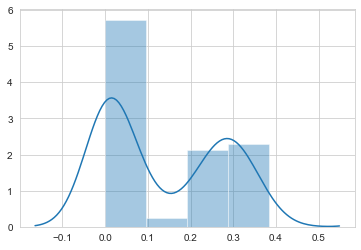

In [17]:
sns.distplot(td_disgmt.factors[1][:, 1])

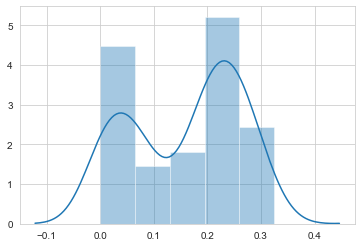

In [18]:
sns.distplot(td_disgmt.factors[1][:, 2])

In [76]:
arr0 = td_disgmt.factors[1][:, 0]
arr1 = td_disgmt.factors[1][:, 1]
arr2 = td_disgmt.factors[1][:, 2]

In [103]:
arr0[27]

0.3604255565872809

In [123]:
start_index = 55
arr0_top = set(list(np.argsort(arr0)[-start_index:]))
arr1_top = set(list(np.argsort(arr1)[-start_index:]))
arr2_top = set(list(np.argsort(arr2)[-start_index:]))

In [131]:
# appears in all three
len(arr0_top & arr1_top & arr2_top)

18

In [125]:
convo_df_subset = corpus.get_conversations_dataframe(selector=lambda convo: convo.meta['longest_path'] >= 8 and 
              convo.get_chronological_utterance_list()[7].meta['disagreement'] == 1)

In [126]:
for idx in (arr0_top & arr1_top & arr2_top):
    convo_id = convo_df_subset.iloc[idx].name
    corpus.get_conversation(convo_id).print_conversation_structure(lambda utt: str(utt.meta['disagreement']), limit=8)

0
    0
        1
            0
                1
                    1
                        1
                            1
0
    0
        1
            1
                1
                    1
                        1
                            1
0
    0
        1
            1
                1
                    1
                        1
                            1
0
    0
        1
            1
                1
                    1
                        1
                            1
0
    0
        0
            1
                1
                    1
                        1
                            1
0
    1
        1
            1
                1
                    1
                        1
                            1
0
    0
        1
            1
                1
                    1
                        1
                            1
0
    1
        0
            1
                1
                    1
                        1
      

In [132]:
len(arr0_top - (arr1_top | arr2_top))

15

In [129]:
for idx in (arr0_top - (arr1_top | arr2_top)):
    convo_id = convo_df_subset.iloc[idx].name
    corpus.get_conversation(convo_id).print_conversation_structure(lambda utt: str(utt.meta['disagreement']), limit=8)

0
    0
        0
            1
                0
                    0
                        1
                            1
0
    0
        1
            1
                1
                    0
                        1
                            1
0
    0
        0
            1
                0
                    0
                        0
                            1
0
    0
        0
            1
                0
                    0
                        0
                            1
0
    0
        1
            1
                0
                    0
                        1
                            1
0
    0
        1
            1
                0
                    0
                        0
                            1
0
    0
        0
            1
                0
                    0
                        0
                            1
0
    0
        1
            1
                0
                    0
                        0
      

In [135]:
len(arr2_top - (arr0_top | arr1_top))

17

In [136]:
for idx in (arr2_top - (arr0_top | arr1_top)):
    convo_id = convo_df_subset.iloc[idx].name
    corpus.get_conversation(convo_id).print_conversation_structure(lambda utt: str(utt.meta['disagreement']), limit=8)

0
    0
        0
            1
                0
                    1
                        1
                            1
0
    0
        1
            0
                0
                    1
                        1
                            1
0
    0
        0
            0
                0
                    1
                        1
                            1
0
    0
        0
            0
                0
                    1
                        1
                            1
0
    0
        1
            0
                0
                    1
                        1
                            1
0
    0
        0
            0
                0
                    1
                        1
                            1
0
    0
        0
            0
                0
                    0
                        1
                            1
0
    0
        0
            0
                0
                    1
                        1
      

In [73]:
len(arr2_top & arr1_top)

22

In [38]:
np.argwhere(arr2 >= np.quantile(td_disgmt.factors[2][:, 1], q=0.66)).flatten()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  15,  16,  17,  18,  21,  22,  23,  24,  25,  26,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  63,  64,  65,  66,  67,  69,  70,
        71,  72,  73,  74,  76,  77,  78,  79,  80,  81,  82,  84,  85,
        86,  88,  89,  90,  91,  92,  93,  94,  95,  97,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126])

### Emphasizing disagreements

In [20]:
corpus.random_utterance()

Utterance({'obj_type': 'utterance', '_owner': <convokit.model.corpus.Corpus object at 0x103f25390>, 'meta': {'post_depth': 3, 'majority_type': None, 'majority_link': 't1_d28jr77', 'annotation-types': ['humor', 'elaboration', 'other'], 'annotation-links': ['t1_d28jr77', 't1_d28jr77', 'none'], 'ups': 2, 'annot-dict': {'agreement': 0, 'announcement': 0, 'answer': 0, 'appreciation': 0, 'disagreement': 0, 'elaboration': 1, 'humor': 1, 'negativereaction': 0, 'other': 1, 'question': 0}, 'agreement': 0, 'announcement': 0, 'answer': 0, 'appreciation': 0, 'disagreement': 0, 'elaboration': 1, 'humor': 1, 'negativereaction': 0, 'other': 1, 'question': 0}, '_id': 't1_d294h9v', 'speaker': Speaker({'obj_type': 'speaker', '_owner': <convokit.model.corpus.Corpus object at 0x103f25390>, 'meta': {}, '_id': 'DSP_GC_98'}), 'conversation_id': 't3_4fg0ul', '_root': 't3_4fg0ul', 'reply_to': 't1_d28jr77', 'timestamp': 0, 'text': 'haha, im from philly so being a smart ass is in my blood. '})

In [26]:
annotation_types = ['agreement',
                     'announcement',
                     'answer',
                     'appreciation',
                     'disagreement',
                     'elaboration',
                     'humor',
                     'negativereaction',
                     'other',
                     'question']

In [29]:
no_maj = 0
no_maj_types = {t: 0 for t in annotation_types}
for utt in corpus.iter_utterances():
    if utt.meta['majority_type'] is None:
        no_maj += 1
        for t in utt.meta['annotation-types']:
            no_maj_types[t] += 1

In [31]:
for t in no_maj_types:
    no_maj_types[t] /= 3961

In [32]:
no_maj_types

{'agreement': 0.3082554910376168,
 'announcement': 0.05023983842464024,
 'answer': 0.26861903559707145,
 'appreciation': 0.3006816460489775,
 'disagreement': 0.24640242363039636,
 'elaboration': 0.7020954304468568,
 'humor': 0.18505427922241857,
 'negativereaction': 0.18808381721787426,
 'other': 0.3287048725069427,
 'question': 0.21560212067659681}

In [24]:
no_maj_elab / no_maj

0.7020954304468568

In [23]:
no_maj

3961

### TSNE

In [34]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [35]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=2000, verbose=1)

In [43]:
type_to_trunc = {
    'agreement': 'agmt',
    'announcement': 'anc',
    'answer': 'ans',
    'appreciation': 'appr',
    'disagreement': 'dsgmt',
    'elaboration': 'elab',
    'humor': 'hmr',
    'negativereaction': 'negR',
    'other': 'othr',
    'question': 'qn'
}

In [48]:
import random

In [64]:
for utt in corpus.iter_utterances():
    if utt.meta['majority_type'] is None:
        if 'disagreement' in utt.meta['annotation-types']:
            utt.meta['majority_type_'] = 'disagreement'
        else:
            utt.meta['majority_type_'] = random.choice(utt.meta['annotation-types'])
    else:
        utt.meta['majority_type_'] = utt.meta['majority_type']

In [65]:
for convo in corpus.iter_conversations():
    convo.meta['path'] = '-'.join([type_to_trunc[utt.meta['majority_type_']] for utt in convo.get_chronological_utterance_list()][:8])

In [ ]:
convo.meta['path']

In [66]:
df = corpus.get_conversations_dataframe(lambda c: c.meta['longest_path'] >= 8 and
                                        c.get_chronological_utterance_list()[7].meta['disagreement'] == 1)
projected_threads = tsne.fit_transform(td_disgmt.factors[1])
print(projected_threads.shape)

xs = [x for (x, y) in projected_threads]
ys = [y for (x, y) in projected_threads]

df['x'] = xs
df['y'] = ys

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 127 samples in 0.000s...
[t-SNE] Computed neighbors for 127 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 127 / 127
[t-SNE] Mean sigma: 0.213288
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.464378
[t-SNE] KL divergence after 1000 iterations: 0.353370
(127, 2)


In [67]:
df

,meta.annot-dict-1,meta.annot-dict-10,meta.annot-dict-11,meta.annot-dict-2,meta.annot-dict-3,meta.annot-dict-4,meta.annot-dict-5,meta.annot-dict-6,meta.annot-dict-7,meta.annot-dict-8,meta.annot-dict-9,meta.longest_path,meta.path,meta.subreddit,meta.title,meta.url,x,y
id,,,,,,,,,,,,,,,,,,
t3_1at5ow,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-agmt-qn-ans-dsgmt-dsgmt-dsgmt,askreddit,What book do you think is beautifully written?,https://www.reddit.com/r/AskReddit/comments/1a...,2.604131,-0.293164
t3_24ffw3,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-dsgmt-dsgmt-dsgmt-dsgmt-dsgmt-dsgmt,askreddit,What is one thing you should never give up on?,https://www.reddit.com/r/AskReddit/comments/24...,-1.041959,4.421836
t3_no05m,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-qn-ans-qn-ans-dsgmt-dsgmt,askreddit,Why do you not believe in aliens?,https://www.reddit.com/r/AskReddit/comments/no...,8.779455,0.771824
t3_1mm7er,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-qn-ans-elab-dsgmt-elab-dsgmt,askuk,UK Broadband/ISP subreddits?,https://www.reddit.com/r/AskUK/comments/1mm7er...,5.996558,4.133040
t3_3yvz6m,"{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,qn-ans-elab-dsgmt-qn-ans-dsgmt-elab,buttcoin,"Do most butters accept global warming? If so, ...",https://www.reddit.com/r/Buttcoin/comments/3yv...,1.988119,0.417150
t3_1tqv73,"{'agreement': 0, 'announcement': 1, 'answer': ...",NaN,NaN,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 1, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...",NaN,8,anc-dsgmt-dsgmt-dsgmt-agmt-agmt-dsgmt-dsgmt,cfb,SI's 'Next Texas Head Coach Bracket' is in the...,https://www.reddit.com/r/CFB/comments/1tqv73/s...,0.772290,-9.832353
t3_12uk6w,"{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreement': 0, 'announcement': 0, 'answer': ...","{'agreeme

In [69]:
import plotly.express as px
fig = px.scatter(df, x='x', y='y', hover_data=['meta.path'])
fig.show()

In [60]:
df.shape

(127, 18)